In [107]:
import torch
import os
import pickle as pkl
import numpy as np
import torchvision
import itertools
import matplotlib.pyplot as plt
from certificate_methods import *
from utils import ReducedModel, parse
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import cv2
import glob

In [108]:
import torch

print(torch.__version__)
print(torchvision.__version__)

1.10.1+cu102
0.11.2+cu102


In [109]:


def scale_batch_images(batch, min_val=0, max_val=1):
    """
    Scales a batch of PyTorch tensors (images) to the specified range [min_val, max_val].

    Args:
        batch (torch.Tensor): A batch of PyTorch tensors (images) to be scaled with shape (batch_size, channels, height, width)
        min_val (float, optional): Minimum value of the target range. Defaults to 0.
        max_val (float, optional): Maximum value of the target range. Defaults to 1.

    Returns:
        torch.Tensor: A new batch of PyTorch tensors with values scaled to the specified range
    """

    batch_min = torch.amin(batch, dim=(1, 2, 3), keepdim=True)
    batch_max = torch.amax(batch, dim=(1, 2, 3), keepdim=True)

    # Normalize the batch of images to [0, 1] range
    normalized_batch = (batch - batch_min) / (batch_max - batch_min)

    # Scale the normalized batch to the target range [min_val, max_val]
    scaled_batch = normalized_batch * (max_val - min_val) + min_val

    return scaled_batch

def man_transform(masked_imgs):
    transformed_images = []
    for img in masked_imgs:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
        timg = torch.tensor(img).unsqueeze(0)  # Add an extra dimension to make it a batch of size 1
    

        normalized_image = (timg/torch.max(timg)- mean) / std
        normalized_image = normalized_image [0]
    

        transformed_images.append(normalized_image)
    stacked_images = torch.stack(transformed_images, dim=0)
    return stacked_images

# Example usage:
# Assuming 'input_batch' is a PyTorch tensor of shape (batch_size, channels, height, width)
# scaled_batch = scale_batch_images(input_batch, 0, 1)
def evaluate(model, images, labels):
    with torch.no_grad():
        outputs = model(images)
        output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
    output_labels = np.argmax(output_probs, axis = 1)
    correct = np.sum(output_labels == labels.numpy())
    total = len(labels)
    print(f" Accuracy: {correct}/{total}: {correct / total}")
def prediction_probs(model, input_data):
    prob_dicts = []
    with torch.no_grad():
        outputs = model(input_data.cuda())
        output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
        print(output_probs.shape)

    output_labels = np.argmax(output_probs, axis = 1)
    for it in output_labels:
        prob_dicts.append({it: output_probs[0][it]})
        
    return prob_dicts

In [110]:
# Model
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var
# LOad trianed weight
x_dim  = 784
hidden_dim = 400
latent_dim = 10
batch_size = 1
model = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

model.load_state_dict(torch.load("Pytorch-VAE-tutorial/enocde_weight.pth"))

model = model.eval()

class Unsupervised(nn.Module):
    
    def __init__(self, basemodel):
        super(Unsupervised, self).__init__()
        self.encoder = basemodel
        self.m = nn.Softmax(dim=1)
 
        
    def forward(self, x):
        x = x.view(1, x_dim)
        mean, var = self.encoder(x)
        z = mean + var
        z = self.m(z)
        return z
unsup = Unsupervised(basemodel=model)
unsup = unsup.eval()


## Load model

In [111]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = '~/datasets'
batch_size = 5
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)


In [112]:
sample, class_num  = iter(test_loader).next()
print(sample.shape)
sample = sample[0:1]
class_num = class_num[0:1]
print(sample.shape)

torch.Size([5, 1, 28, 28])
torch.Size([1, 1, 28, 28])


## load sample images and labels

(1, 10)
The output cluster and the probability of them:  [{3: 0.23196931}]


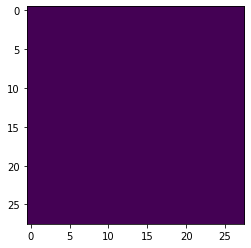

In [144]:
input_image = sample.cuda() #+ torch.normal(.5, 0.16, size=input_tensor.shape).cuda()
#input_image = torch.ones(size=sample.shape).cuda() * 255
plt.imshow(input_image[0].permute(1, 2, 0).cpu().numpy())
#all_images = scale_batch_images(all_images)
label = torch.tensor([class_num]).cuda()
#input_images = man_transform(all_images).cuda()
probdict = prediction_probs(unsup.cuda(), input_image)
print("The output cluster and the probability of them: ", probdict)


## Noise base. It is the baseline for removing feature

In [145]:
noise_images = torch.from_numpy(np.load('./noise_images.npy'))
print("Number of noise image: " , len(noise_images))
# Use grey:
noise_images = None
#print(noise_images.shape)

Number of noise image:  100


In [154]:
K = 1
scale = 4
lr = 0.5
steps = 5000
obj = 'xent'
noise_bs = 10
reg_l1 = 2e-05
reg_tv = 0.01
reg_ent = 0.0
debug = True
model = unsup.cuda()

In [155]:
print(input_image.shape)
with torch.no_grad():
    outputs = model(input_image.cuda())
    output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
print("Total classes in the model: ", len(output_probs[0]))
#Force explnation
output_labels = np.argmax(output_probs, axis = 1)
output_labels = [1]
probs = torch.zeros(input_image.shape[0], 200)
for target_label in output_labels:
    probs[:, target_label] = 1

batch_masked_model = learn_masks_for_batch_Kcert(
                model, input_image, target_probs=probs, K=K, scale=scale,
                opt=optim.Adam, lr=lr, steps=steps, obj=obj,
                noise_mean=None, noise_batch=noise_images, noise_bs=noise_bs,
                reg_l1=reg_l1, reg_tv=reg_tv, reg_ent=reg_ent, old_mask=None, debug=debug)
masks = batch_masked_model.mask().detach().cpu()


torch.Size([1, 1, 28, 28])
Total classes in the model:  10
1 4 0.5 5000 xent 10 2e-05 0.01 0.0
4999: loss: 2.17, l1 norm: 5, tv: 0.03, ent: 0.03, pred prob: 0.2319


In [156]:
prob_dicts = []
probs = batch_masked_model(model ,input_image, masks=masks.cuda()[0])
print(probs)
prediction_labels = torch.argmax(probs, axis = 1)
for it in prediction_labels:
    prob_dicts.append({it.item(): probs[0][it].detach().item()})
print(prob_dicts)

tensor([[0.0853, 0.2319, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[{1: 0.23191052675247192}]


torch.Size([2, 1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor(1.)


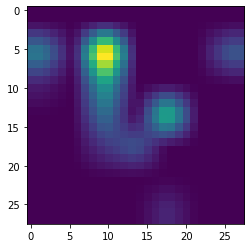

In [157]:
print(masks.shape)
heatmap = masks[0]
neg_heatmap = masks[1]
print(heatmap.shape)

# normalize heatmap 
#heatmap = scale_batch_images(heatmap)

#plt.close()
heatmap = scale_batch_images(heatmap)
print(torch.max(heatmap[0][0]))
plt.imshow(heatmap.cpu().numpy()[0][0])

AttributeError: 'AxesSubplot' object has no attribute 'flat'

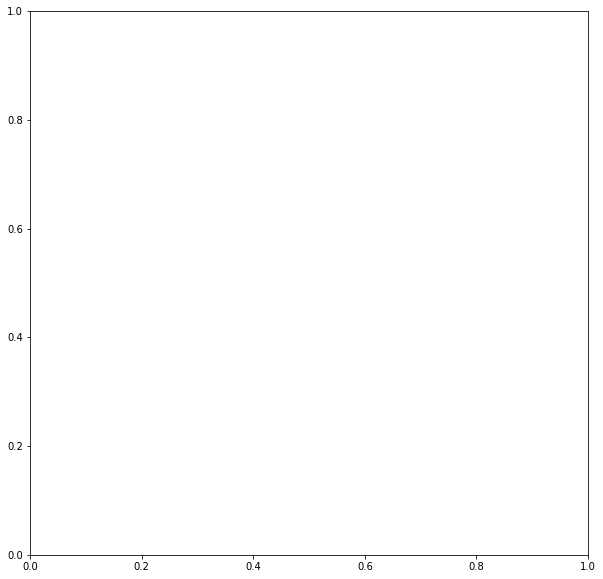

In [158]:


def scale_image_to_255(image_array):
    """
    Scales the input image array to the range [0, 255].

    Args:
        image_array (np.array): A NumPy array representing an image

    Returns:
        np.array: A new NumPy array with pixel values scaled to the range [0, 255]
    """
    print(image_array)
    # Find the minimum and maximum pixel values
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    # Scale the image array to the range [0, 255]
    scaled_image_array = 255 * (image_array - min_val) / (max_val - min_val)

    return scaled_image_array


def plot_image_grid(images_array):
    """
    Plots a grid of images from a NumPy array.

    Args:
    images_array (numpy.ndarray): A NumPy array of images with shape (num_images, height, width) or (num_images, height, width, channels)
    """

    # Determine the grid size based on the number of images
    grid_size = int(np.ceil(np.sqrt(len(images_array))))

    # Create the figure and axes objects
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    # Iterate through the axes and plot the images
    for i, ax in enumerate(axes.flat):
        if i < len(images_array):
            # Remove x-axis and y-axis ticks
            ax.set_xticks([])
            ax.set_yticks([])

            # Plot the image on the current axis
            if images_array.shape[1] == 1:
                img = images_array[i][0] 
            else:
                img = np.transpose(images_array[i], (1, 2, 0))

            ax.imshow(img, cmap='gray' if images_array.shape[1] == 1 else None)
        else:
            # Remove the empty subplot
            fig.delaxes(ax)

    # Add space between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Display the grid of images
    plt.show()
plot_image_grid(heatmap)
plot_image_grid(images.numpy())

torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


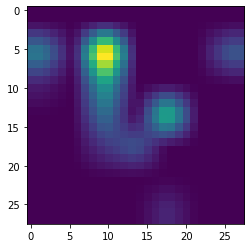

In [159]:


def apply_masks_to_images(images_list, masks_list):
    """
    Applies individual single-channel masks to a list of channel-first 3-channel images.

    Args:
        images_list (list of np.array): A list of channel-first 3-channel images, each with shape (3, height, width)
        masks_list (list of np.array): A list of single-channel masks, each with shape (height, width)

    Returns:
        list of np.array: A list of masked channel-first images, each with shape (3, height, width)
    """

    if len(images_list) != len(masks_list):
        raise ValueError("The number of images and masks must be equal")

    masked_images = []

    for image, mask in zip(images_list, masks_list):
        if len(image.shape) != 3 or image.shape[0] != 1:
            raise ValueError("Each input image must have a shape of (3, height, width)")
        print(mask.shape)
        if len(mask.shape) != 3:
            raise ValueError("Each input mask must have a shape of (channel, height, width)")

        # Expand the mask to match the shape of the image
        s_mask = mask[0]
        expanded_mask =  s_mask#.unsqueeze(0).repeat(3, 1, 1)
        # Multiply the image with the expanded mask
        masked_image = image * expanded_mask

        # Add the masked image to the list
        masked_images.append(masked_image)
    masked_images = torch.stack(masked_images, axis=0)
    return masked_images
#plt.imshow(neg_heatmap[0][0])
print(heatmap.shape)
masked_image = apply_masks_to_images(input_image, heatmap.cuda())

masked_image_vis = scale_batch_images(masked_image)


plt.imshow(masked_image[0].permute(1, 2, 0).cpu().numpy())
image = transforms.ToPILImage()(masked_image_vis[0])

# Save the PIL image to a file
image.save("image.jpeg")

Masked images shape:  torch.Size([1, 1, 28, 28])
Masked image max, min:  tensor(255., device='cuda:0') tensor(0., device='cuda:0')
(1, 10)
The output and the probability of them:  [{1: 0.23196931}]


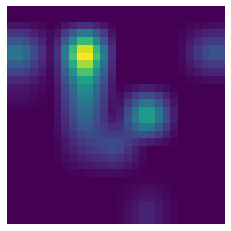

In [160]:
print("Masked images shape: ",masked_image.shape)
print("Masked image max, min: ", torch.max(masked_image), torch.min(masked_image))
masked_input = masked_image.clone().detach().cuda()
#acc = evaluate(model,masked_image, label)
probdict = prediction_probs(model, masked_image)
print("The output and the probability of them: ", probdict)
plt.imshow(masked_image[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
#plt.title(f"{data_dict[str(list(probdict[0].keys())[0])][1]}:{list(probdict[0].values())[0]}")
plt.show()

In [103]:
masked_input = masked_image.clone().detach().cuda()
acc = evaluate(model,masked_image, label)
probdict = prediction_probs(model,masked_image)
print("The output and the probability of them: ", probdict)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Masked images shape:  torch.Size([1, 3, 224, 224])
Masked image max, min:  tensor(0.1331) tensor(0.)
 Accuracy: 1/1: 1.0
The output and the probability of them:  [{782: 0.99647576}]